In [1]:
from copy import copy
import random
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torch.utils.data import random_split, Subset
from torch.optim import lr_scheduler


import albumentations as A  # Image augmentations

from mri_dataset import get_mri_datasets
# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
else:
    print("No cuda device")

INFO:albumentations.check_version:A new version of Albumentations is available: 2.0.8 (you have 1.4.11). Upgrade using: pip install --upgrade albumentations


In [2]:
import torch, platform
print("torch:", torch.__version__)
print("built with CUDA:", torch.version.cuda)
print("CUDA available:", torch.cuda.is_available())
print("cuDNN:", torch.backends.cudnn.version())

torch: 1.8.1
built with CUDA: 11.1
CUDA available: True
cuDNN: 8005


In [3]:
from song_code_reproduction.src.mri_vit import ViT_Encoder_Decoder


In [4]:
save_path = "/dt/yisroel/Users/Data_Memorization/song_memorization/LSB/mri/"

memorization_size = 100

# Training Params
BATCH_SIZE = 16
num_epochs = 500 # Example number of epochs
LEARNING_RATE = 1e-4

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda:0")


In [5]:
mem_transform = A.Compose([
                            A.Resize(width=128, height=128, p=1.0),
])
# transforms.Lambda(lambda t: (t*255).byte().permute(1,2,0).numpy())

mem_train_dataset, train_dataset, val_dataset, test_dataset = get_mri_datasets(root_path='mri_data/',
                                                                               mem_train_transform_obj=mem_transform)

trainloader = DataLoader(train_dataset, 
                      BATCH_SIZE, 
                      shuffle=True, 
                      num_workers=6,  
                      pin_memory=True)  
valloader = DataLoader(val_dataset, 
                    BATCH_SIZE,   
                    num_workers=6, 
                    pin_memory=True)

testloader = DataLoader(test_dataset, 
                    BATCH_SIZE,   
                    num_workers=6, 
                    pin_memory=True)


if memorization_size > len(mem_train_dataset):
    memorization_size = len(mem_train_dataset)
    
memorization_indices = torch.randperm(len(mem_train_dataset))[:memorization_size]
memorization_set = Subset(mem_train_dataset, memorization_indices.tolist())


print("DataLoaders created successfully!")
print(f"Number of images in training set: {len(train_dataset)}")
print(f"Number of images in validation set: {len(val_dataset)}")
print(f"Number of images in test set: {len(test_dataset)}")
print(f"Number of images in memorization set: {len(memorization_set)}")

DataLoaders created successfully!
Number of images in training set: 3182
Number of images in validation set: 393
Number of images in test set: 354
Number of images in memorization set: 100


In [6]:
model = ViT_Encoder_Decoder().to(device)

In [7]:
def dice_coef_metric(pred, label):
    intersection = 2.0 * (pred * label).sum()
    union = pred.sum() + label.sum()
    if pred.sum() == 0 and label.sum() == 0:
        return 1.
    return intersection / union

# Function to calculate the Dice coefficient loss between prediction and ground truth.
def dice_coef_loss(pred, label):
    smooth = 1.0
    intersection = 2.0 * (pred * label).sum() + smooth
    union = pred.sum() + label.sum() + smooth
    return 1 - (intersection / union)

# Function to calculate the combined BCE (Binary Cross Entropy) and Dice loss.

def bce_dice_loss(pred, label):
    pred = torch.sigmoid(pred) 
    dice_loss = dice_coef_loss(pred, label)
    bce_loss = nn.BCELoss()(pred, label)
    return dice_loss + bce_loss

criterion = bce_dice_loss
optimizer = optim.AdamW(model.parameters(), lr= LEARNING_RATE)

scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

print("Training hyperparameters and objects defined.")
print(f"Learning Rate: {LEARNING_RATE}")
print(f"Number of Epochs: {num_epochs}")
print(f"Loss Function: {type(criterion).__name__}")
print(f"Optimizer Type: {type(optimizer).__name__}")
print(f"Scheduler Type: {type(scheduler).__name__}")
print(f"Device: {device}")

Training hyperparameters and objects defined.
Learning Rate: 0.0001
Number of Epochs: 500
Loss Function: function
Optimizer Type: AdamW
Scheduler Type: CosineAnnealingLR
Device: cuda:0


In [8]:
import torch
import time
import os

def train_batch(images, labels, model, optimizer, criterion, device):
    images, labels = images.to(device), labels.to(device)

    # Forward pass
    outputs = model(images)
    loss = criterion(outputs, labels)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item()

def evaluate_batch(images, mask, model, criterion, device):
    images, mask = images.to(device), mask.to(device)
    with torch.no_grad():
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, mask)

        # Calculate accuracy
        out_cut = np.copy(outputs.data.cpu().numpy())
        out_cut[np.nonzero(out_cut < 0.5)] = 0.0
        out_cut[np.nonzero(out_cut >= 0.5)] = 1.0
        dice = dice_coef_metric(out_cut, mask.data.cpu().numpy())

    return loss.item(), dice, mask.size(0)

def main_train_loop(model, trainloader, valloader, optimizer, criterion, scheduler, num_epochs, device, save_path):
    best_val_dice = 0.0

    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        start_time = time.time()

        # Training phase
        for i, (images, labels) in enumerate(trainloader):
            loss = train_batch(images, labels, model, optimizer, criterion, device)
            running_loss += loss

        epoch_loss = running_loss / len(trainloader)

        # Validation phase
        model.eval()
        val_loss = 0.0
        dice_predictions = 0
        total_predictions = 0
        for images, labels in valloader:
            loss, dice, _ = evaluate_batch(images, labels, model, criterion, device)
            val_loss += loss
            dice_predictions += dice
            total_predictions += 1

        epoch_val_loss = val_loss / len(valloader)
        dice = dice_predictions / total_predictions

        end_time = time.time()
        epoch_time = end_time - start_time

        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {epoch_loss:.4f}, '
              f'Val Loss: {epoch_val_loss:.4f}, '
              f'Val Dice: {dice:.4f}, '
              f'Epoch Time: {epoch_time:.2f}s')

        # Step the scheduler
        scheduler.step()

        # Save the best model
        if dice > best_val_dice:
            best_val_dice = dice
            model_save_path = os.path.join(save_path, 'best_model.pth')
            torch.save(model.state_dict(), model_save_path)
            print(f"Saved best model to {model_save_path} with validation DICE: {best_val_dice:.4f}")


        model.train() # Set model back to training mode


    print('Finished Training')


In [9]:
# main_train_loop(model, trainloader, valloader, optimizer, criterion, scheduler, num_epochs, device, save_path)

## Test model after training

In [10]:
import torch
import os

# Define the path to the saved model
save_path = "/dt/yisroel/Users/Data_Memorization/song_memorization/LSB/mri/"
model_save_path = os.path.join(save_path, 'best_model.pth')

# Instantiate the model (make sure the model architecture is defined in a previous cell)
# Assuming 'model' is already defined and is an instance of your ViT class
# model = VisionTransformer(...) # If not already defined, define it here with the correct parameters

# Load the saved state dictionary
if os.path.exists(model_save_path):
    model.load_state_dict(torch.load(model_save_path))
    print(f"Model loaded successfully from {model_save_path}")
else:
    print(f"No model found at {model_save_path}")

# Move the model to the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print(f"Model is on device: {next(model.parameters()).device}")

Model loaded successfully from /dt/yisroel/Users/Data_Memorization/song_memorization/LSB/mri/best_model.pth
Model is on device: cuda:0


In [11]:
import torch

def test_model(model, testloader, device):
    # Set the model to evaluation mode
    model.eval()

    test_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    # Iterate over the test data
    with torch.no_grad():
        for images, labels in testloader:
            loss, correct, _ = evaluate_batch(images, labels, model, criterion, device)
            test_loss += loss
            correct_predictions += correct
            total_predictions += 1

    # Calculate average test loss and accuracy
    average_test_loss = test_loss / len(testloader)
    test_accuracy = correct_predictions / total_predictions

    print(f'Test Loss: {average_test_loss:.4f}, Test DICE: {test_accuracy:.4f}')

## LSB encoding test

In [12]:
from song_code_reproduction.src.robust_lsb_encoding import (build_tail_payload_from_mri_data,
                                                            model_capacity_last_byte,
                                                            embed_bytes_into_model_last_byte,
                                                            extract_all_bytes_from_model_last_byte,
                                                            forgiving_tail_parse_from_end)

from song_code_reproduction.src.pruning import prune_model_global_l1

from song_code_reproduction.src.ssim_eval import ssim

In [13]:
def calc_ssim(memorization_size, recovered_imgs, memorization_set):
    ssim_scores = []
    for i in range(memorization_size):
        with torch.no_grad():
            src = (memorization_set[i][0].permute(1, 2, 0).unsqueeze(0)*255).float()
            dec = torch.from_numpy(recovered_imgs[i]).unsqueeze(0).float()
            ssim_score = 0.5*(1+ssim(dec, src))
            ssim_scores.append(ssim_score)
    ssim_scores = torch.tensor(ssim_scores)
    return ssim_scores.mean()



In [14]:
# 1) Build payload
payload, metas = build_tail_payload_from_mri_data(memorization_set, max_images=memorization_size)

# 2) Embed AT THE END
cap = model_capacity_last_byte(model)
if len(payload) > cap: raise RuntimeError(f"Payload {len(payload)} > cap {cap}")
_ = embed_bytes_into_model_last_byte(model, payload, from_end=True)

# 3) Immediate round-trip sanity (no pruning)
rb_all = extract_all_bytes_from_model_last_byte(model)
assert rb_all[-len(payload):] == payload, "Tail embed mismatch (should never happen without pruning)"

# 4) Decode from END
imgs = forgiving_tail_parse_from_end(rb_all, metas)
print("Recovered", len(imgs), "images (no pruning)")

print("SSIM before pruning: ", calc_ssim(memorization_size=memorization_size, recovered_imgs=imgs,
                memorization_set=memorization_set).item())
test_model(model, testloader, device)

# ---- prune the model here ----
pruned_model = prune_model_global_l1(model, 0.2)

# 5) After pruning, decode from END again (works even if bytes flipped/zeroed)
rb_all_after = extract_all_bytes_from_model_last_byte(pruned_model)
imgs_after = forgiving_tail_parse_from_end(rb_all_after, metas)
print("Recovered after pruning:", len(imgs_after))
print("SSIM After pruning: ", calc_ssim(memorization_size=memorization_size, recovered_imgs=imgs_after,
                memorization_set=memorization_set).item())
test_model(pruned_model, testloader, device)

Recovered 100 images (no pruning)


/tmp/ipykernel_3897983/3841161421.py:6: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1616554793803/work/torch/csrc/utils/tensor_numpy.cpp:143.)
  dec = torch.from_numpy(recovered_imgs[i]).unsqueeze(0).float()


SSIM before pruning:  0.9796935319900513
Test Loss: 0.1537, Test DICE: 0.8711
Recovered after pruning: 100
SSIM After pruning:  0.78687584400177
Test Loss: 0.1527, Test DICE: 0.8714


In [138]:
memorization_set[0][0]

tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0010, 0.0010, 0.0010,  ..., 0.0000, 0.0000, 0.0000],
         [0.0078, 0.0088, 0.0049,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0059, 0.0069, 0.0059,  ..., 0.0098, 0.0078, 0.0020],
         [0.0069, 0.0078, 0.0078,  ..., 0.0000, 0.0000, 0.0000],
         [0.0039, 0.0088, 0.0088,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0029, 0.0069, 0.0069,  ..., 0.0098, 0.0069, 0.0039],
         [0.0039, 0.0069, 0.0098,  ..., 0.0108, 0.0157, 0.0118],
         [0.0049, 0.0137, 0.0157,  ..., 0.0108, 0.0118, 0.0127],
         ...,
         [0.0029, 0.0108, 0.0059,  ..., 0.0206, 0.0078, 0.0127],
         [0.0039, 0.0108, 0.0069,  ..., 0.0176, 0.0157, 0.0069],
         [0.0039, 0.0078, 0.0088,  ..., 0.0069, 0.0098, 0.0098]],

        [[0.0029, 0.0020, 0.0020,  ..., 0.0098, 0.0098, 0.0000],
         [0.0118, 0.0098, 0.0078,  ..., 0.0098, 0.0098, 0.0000],
         [0.0098, 0.0078, 0.0059,  ..., 0.0127, 0.0098, 0.

In [124]:
import matplotlib.pyplot as plt


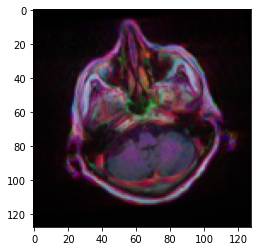

In [125]:
plt.imshow(torch.tensor(imgs[1]))
plt.show()

In [126]:
memorization_set[0][0].shape

torch.Size([3, 128, 128])

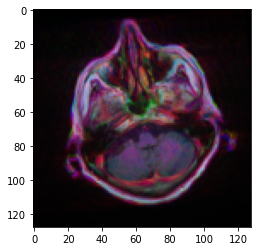

In [127]:
plt.imshow(memorization_set[1][0].permute(1, 2, 0))
plt.show()